# Table of Contents.

# Library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import regex as re

from itertools import chain
from datetime import datetime as dt
from scipy.stats import ttest_ind
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

# Data Sets.

In [2]:
Purchase = pd.read_csv('QVI_purchase_behaviour.csv')
Transaction = pd.ExcelFile('QVI_transaction_data.xlsx').parse(0)

# Exploratory Data Analysis.

## Purchase

In [3]:
Purchase.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
print('Column              Nulls')
print('-' * 26)
print(Purchase.isnull().sum())
print('\nColumn              Dtypes')
print('-' * 26)
Purchase.dtypes

Column              Nulls
--------------------------
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Column              Dtypes
--------------------------


LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [5]:
print('Value counts in LIFESTAGE:')
print('-'*32)
print(Purchase['LIFESTAGE'].value_counts())

print('\n\nValue counts in PREMIUM_CUSTOMER:')
print('-'*34)
print(Purchase['PREMIUM_CUSTOMER'].value_counts())

Value counts in LIFESTAGE:
--------------------------------
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64


Value counts in PREMIUM_CUSTOMER:
----------------------------------
Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64


E:\anaconda3\lib\site-packages\seaborn\distributions.py:516: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout = self.ax.fill_between([], [], color=color, **plot_kws)


<AxesSubplot:xlabel='Count', ylabel='LIFESTAGE'>

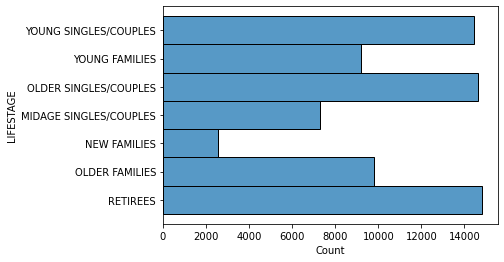

In [6]:
sns.histplot(y = 'LIFESTAGE', data = Purchase)

#### Discussion.
Majority of our customers seem to be retirees, and both young and old singles/couples. Perhaps, these may be our groups of interest but further investigation would be required.

E:\anaconda3\lib\site-packages\seaborn\distributions.py:516: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout = self.ax.fill_between([], [], color=color, **plot_kws)


<AxesSubplot:xlabel='PREMIUM_CUSTOMER', ylabel='Count'>

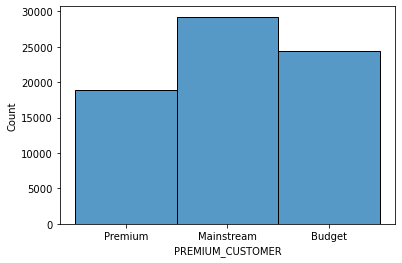

In [7]:
sns.histplot(x = 'PREMIUM_CUSTOMER', data = Purchase)

## Transaction.

In [8]:
Transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [9]:
print('Column            Nulls')
print('-' * 23)
print(Transaction.isnull().sum())

print('\nColumn            Dtypes')
print('-' * 26)
print(Transaction.dtypes)
Transaction.STORE_NBR = Transaction.STORE_NBR.astype('str')

Column            Nulls
-----------------------
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Column            Dtypes
--------------------------
DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


### DateType conversion.

In [10]:
origin = pd.Timestamp('1899-12-30')
Transaction['DATE'] = Transaction['DATE'].apply(lambda x: origin + pd.Timedelta(days = x))
Transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


### Item Filtering.
Since I'm only concerned with chips, I have to take a look at what items are being sold in the store.

In [11]:
sorted(Transaction['PROD_NAME'].unique())

['Burger Rings 220g',
 'CCs Nacho Cheese    175g',
 'CCs Original 175g',
 'CCs Tasty Cheese    175g',
 'Cheetos Chs & Bacon Balls 190g',
 'Cheetos Puffs 165g',
 'Cheezels Cheese 330g',
 'Cheezels Cheese Box 125g',
 'Cobs Popd Sea Salt  Chips 110g',
 'Cobs Popd Sour Crm  &Chives Chips 110g',
 'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g',
 'Dorito Corn Chp     Supreme 380g',
 'Doritos Cheese      Supreme 330g',
 'Doritos Corn Chip Mexican Jalapeno 150g',
 'Doritos Corn Chip Southern Chicken 150g',
 'Doritos Corn Chips  Cheese Supreme 170g',
 'Doritos Corn Chips  Nacho Cheese 170g',
 'Doritos Corn Chips  Original 170g',
 'Doritos Mexicana    170g',
 'Doritos Salsa       Medium 300g',
 'Doritos Salsa Mild  300g',
 'French Fries Potato Chips 175g',
 'Grain Waves         Sweet Chilli 210g',
 'Grain Waves Sour    Cream&Chives 210G',
 'GrnWves Plus Btroot & Chilli Jam 180g',
 'Infuzions BBQ Rib   Prawn Crackers 110g',
 'Infuzions Mango     Chutny Papadums 70g',
 'Infuzions SourCream&Herbs Veg St

In [12]:
Words = Transaction['PROD_NAME'].apply(lambda x: nltk.word_tokenize(x))

In [13]:
Words2 = list(chain.from_iterable(Words))
freqdist1 = nltk.FreqDist(Words2)
freqdist1 = dict(sorted(freqdist1.items(), key = lambda kv:kv[1], reverse = True))

print('Tokens' + ' ' * 15 + 'Count')
print('-' * 27)
for k,v in freqdist1.items():
    print(f"{k:<18} : {v}")

Tokens               Count
---------------------------
&                  : 82244
175g               : 60561
Chips              : 49770
150g               : 41633
Kettle             : 41288
Smiths             : 28860
Salt               : 27976
Cheese             : 27890
Pringles           : 25102
134g               : 25102
Doritos            : 24962
Crinkle            : 23960
110g               : 22387
Corn               : 22063
Original           : 21560
Cut                : 20754
Chip               : 18645
170g               : 18502
Salsa              : 18094
Chicken            : 15407
Chilli             : 15390
165g               : 15297
Sea                : 14145
Thins              : 14075
Sour               : 13882
Crisps             : 12607
330g               : 12540
Vinegar            : 12402
300g               : 12041
RRD                : 11894
Sweet              : 11060
Infuzions          : 11057
Supreme            : 10963
Chives             : 10951
Cream              : 10723


In [14]:
# Filtering out symbols and numerics.
Words2 = [x for x in Words2 if x.isalpha()]
freqdist1 = nltk.FreqDist(Words2)
freqdist1 = dict(sorted(freqdist1.items(), key = lambda kv:kv[1], reverse = True))

print('Tokens' + ' ' * 12 + 'Count')
print('-' * 24)
for k,v in freqdist1.items():
    print(f"{k:<15} : {v}")

Tokens            Count
------------------------
Chips           : 49770
Kettle          : 41288
Smiths          : 28860
Salt            : 27976
Cheese          : 27890
Pringles        : 25102
Doritos         : 24962
Crinkle         : 23960
Corn            : 22063
Original        : 21560
Cut             : 20754
Chip            : 18645
Salsa           : 18094
Chicken         : 15407
Chilli          : 15390
Sea             : 14145
Thins           : 14075
Sour            : 13882
Crisps          : 12607
Vinegar         : 12402
RRD             : 11894
Sweet           : 11060
Infuzions       : 11057
Supreme         : 10963
Chives          : 10951
Cream           : 10723
WW              : 10320
Cobs            : 9693
Popd            : 9693
Tortilla        : 9580
Tostitos        : 9471
Twisties        : 9454
BBQ             : 9434
Sensations      : 9429
Lime            : 9347
Old             : 9324
El              : 9324
Paso            : 9324
Dip             : 9324
Tomato          : 7669
Thin

### Filtering out Salsa-related items.

In [15]:
Chips = Transaction['PROD_NAME'].apply(lambda x: 'Salsa' not in x)
Chips = Transaction.loc[Chips]
Chips

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


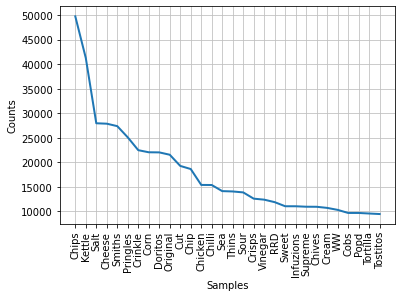

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [16]:
Tokens = Chips['PROD_NAME'].apply(lambda x: nltk.word_tokenize(x))
Tokens = list(chain.from_iterable(Tokens))
Tokens = [x for x in Tokens if x.isalpha()]
Token_Count = nltk.FreqDist(Tokens)
Token_Count.plot(30)

In [17]:
Chips.describe()

,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


#### Discussion.
There's an anomaly in the quantity of products purchased. The maximum number of items purchased is 200, which could potentially be stocks for a business. It should be looked into.

## Anomalies.

### High Purchase Count.

In [18]:
Transaction[Transaction['TOT_SALES']==650]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [19]:
CustomerID = Transaction['LYLTY_CARD_NBR'][Transaction['TOT_SALES']==650].unique()[0]
CustomerID

226000

In [20]:
Purchase[Purchase['LYLTY_CARD_NBR']==CustomerID]

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
59694,226000,OLDER FAMILIES,Premium


#### Discussion.
The person who purchased the 200 packets is a premium customer and a part of the Older Families category. This further supports my theory that it was for replenishing stock for a business.

In [21]:
Purchase = Purchase[Purchase['LYLTY_CARD_NBR'] != CustomerID]
Transaction = Transaction[Transaction['LYLTY_CARD_NBR'] != CustomerID]

### Missing Values.
I decide to look through the dates to see if the store is open all year round.

In [22]:
Grp_Trans = Transaction.groupby(['DATE'])
Grp = pd.DataFrame(Grp_Trans.size())
Grp = Grp.rename(columns = {0: 'COUNT'})
Grp

,COUNT
DATE,
2018-07-01,724
2018-07-02,711
2018-07-03,722
2018-07-04,714
2018-07-05,712
...,...
2019-06-26,723
2019-06-27,709
2019-06-28,730


#### Discussion.
The stores only has transactions for 364/365 days. Why is that?

In [23]:
SeqDates = pd.DataFrame(pd.date_range(start = '07/01/2018', end = '06/30/2019').tolist())
SeqDates = SeqDates.rename(columns = {0: 'DATE'})

MergedDates = pd.merge(Grp, SeqDates, on='DATE', how = 'outer')
MergedDates = MergedDates.sort_values(by = 'DATE')
MergedDates

,DATE,COUNT
0,2018-07-01,724.0
1,2018-07-02,711.0
2,2018-07-03,722.0
3,2018-07-04,714.0
4,2018-07-05,712.0
...,...,...
359,2019-06-26,723.0
360,2019-06-27,709.0
361,2019-06-28,730.0
362,2019-06-29,745.0


In [24]:
MergedDates['DATE'][MergedDates['COUNT'].isnull()]

364   2018-12-25
Name: DATE, dtype: datetime64[ns]

#### Discussion.
It turns out that the store was closed on Christmas.

### Total Sales by Month.
This is where I look at the distribution of sales by month to identify which month was our most lucrative month.

<AxesSubplot:xlabel='DATE'>

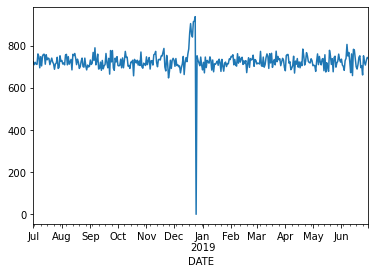

In [25]:
MergedDates.groupby(['DATE']).sum()['COUNT'].plot()

#### Discussion.
It turns out that December is our most lucrative month and it plummets to 0 over Christmas as the store is closed.

### Total Sales in December.
Now I delve deeper into the sales in December to identify which brands or pack weights are the most lucrative.

<AxesSubplot:xlabel='DATE'>

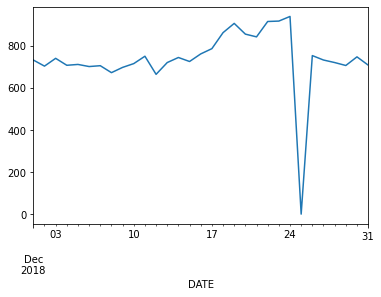

In [27]:
December = pd.DataFrame(MergedDates[MergedDates['DATE'].dt.month == 12])
December.groupby(['DATE']).sum()['COUNT'].plot()

### Pack sizes.

The minimum weight of the packs is 70g and the maximum weight is 380g


E:\anaconda3\lib\site-packages\seaborn\distributions.py:516: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout = self.ax.fill_between([], [], color=color, **plot_kws)


<AxesSubplot:ylabel='Count'>

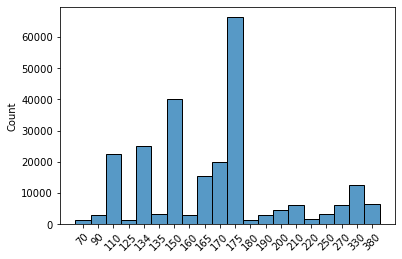

In [28]:
Pack_Size = Chips['PROD_NAME'].apply(lambda x: re.findall(r'\d+', x))
Pack_Size = list(chain.from_iterable(Pack_Size))
Set_Size = sorted(set(Pack_Size), key = int)
print('The minimum weight of the packs is %sg and the maximum weight is %sg' %(Set_Size[0], Set_Size[-1]))

plt.xticks(rotation = 45)
Pack_Size.sort(key = int)
sns.histplot(Pack_Size)

### Brands of Chips.

In [29]:
Chips['BRAND'] = Chips['PROD_NAME'].apply(lambda x: x.split(' ')[0])
sorted(Chips['BRAND'].unique())

C:\Users\HP-user\AppData\Local\Temp\ipykernel_9056\2485027275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chips['BRAND'] = Chips['PROD_NAME'].apply(lambda x: x.split(' ')[0])


['Burger',
 'CCs',
 'Cheetos',
 'Cheezels',
 'Cobs',
 'Dorito',
 'Doritos',
 'French',
 'Grain',
 'GrnWves',
 'Infuzions',
 'Infzns',
 'Kettle',
 'NCC',
 'Natural',
 'Pringles',
 'RRD',
 'Red',
 'Smith',
 'Smiths',
 'Snbts',
 'Sunbites',
 'Thins',
 'Tostitos',
 'Twisties',
 'Tyrrells',
 'WW',
 'Woolworths']

In [30]:
# Renaming brands for consistency.
Chips.loc[Chips['BRAND'] == 'RRD', 'BRAND'] = 'Red'
Chips.loc[Chips['BRAND'] == 'Dorito', 'BRAND'] = 'Doritos'
Chips.loc[Chips['BRAND'] == 'Smith', 'BRAND'] = 'Smiths'
Chips.loc[Chips['BRAND'] == 'Snbts', 'BRAND'] = 'Sunbites'
Chips.loc[Chips['BRAND'] == 'GrnWves', 'BRAND'] = 'Grain'
Chips.loc[Chips['BRAND'] == 'NCC', 'BRAND'] = 'Natural'
Chips.loc[Chips['BRAND'] == 'WW', 'BRAND'] = 'Woolworths'
Chips.loc[Chips['BRAND'] == 'Infzns', 'BRAND'] = 'Infuzions'
sorted(Chips['BRAND'].unique())

['Burger',
 'CCs',
 'Cheetos',
 'Cheezels',
 'Cobs',
 'Doritos',
 'French',
 'Grain',
 'Infuzions',
 'Kettle',
 'Natural',
 'Pringles',
 'Red',
 'Smiths',
 'Sunbites',
 'Thins',
 'Tostitos',
 'Twisties',
 'Tyrrells',
 'Woolworths']

In [31]:
ChipPurchases = pd.merge(Chips, Purchase, how = 'inner')
print('There are %d entries in the Purchase dataset.\n\
There are %d entries in the merged dataset.' %(len(Chips), len(ChipPurchases)))

print('\nColumn            Nulls')
print('-' * 23)
print(ChipPurchases.isnull().sum())

There are 246742 entries in the Purchase dataset.
There are 246740 entries in the merged dataset.

Column            Nulls
-----------------------
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


There are two less entries in the merged dataset because of the one customer from before that purchased over 200 packets of chips for a store.

In [32]:
ChipPurchases.to_csv('QVI_data.csv')

## Data Analysis.

### Total Sales by LifeStage.

In [33]:
ChipPurchases

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,Kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,Tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,Doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,Doritos,YOUNG SINGLES/COUPLES,Premium


In [34]:
y = pd.DataFrame(ChipPurchases.groupby(['LIFESTAGE']).sum()['TOT_SALES'])
y

,TOT_SALES
LIFESTAGE,
MIDAGE SINGLES/COUPLES,172523.80
NEW FAMILIES,47347.95
OLDER FAMILIES,328519.90
OLDER SINGLES/COUPLES,376019.65
RETIREES,342381.90
YOUNG FAMILIES,294627.90
YOUNG SINGLES/COUPLES,243756.60


<AxesSubplot:ylabel='LIFESTAGE'>

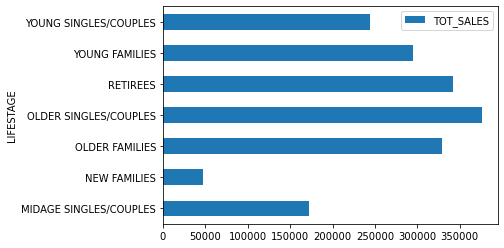

In [35]:
y.plot(kind = 'barh')

#### Discussion.
As the plot suggests, the majority of our sales come from older singles/couples, followed by retirees and lastly, older families. It may be worth targetting these groups but more investigation is needed with regards to which brand these groups prefer, or the size of the packets.

### Total Sales by Premium Customer.

In [36]:
y = pd.DataFrame(ChipPurchases.groupby(['PREMIUM_CUSTOMER']).sum()['TOT_SALES'])
y

,TOT_SALES
PREMIUM_CUSTOMER,
Budget,631406.85
Mainstream,700865.40
Premium,472905.45


<AxesSubplot:ylabel='PREMIUM_CUSTOMER'>

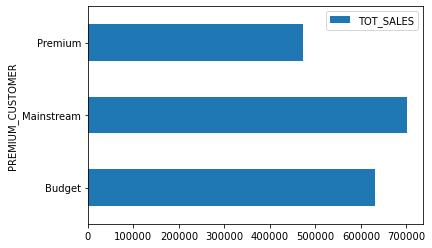

In [37]:
y.plot(kind = 'barh')

#### Discussion.
As the plot suggests, most of our customers belong to the Mainstream stream, followed by the Budget stream.

<AxesSubplot:xlabel='TOT_SALES', ylabel='BRAND'>

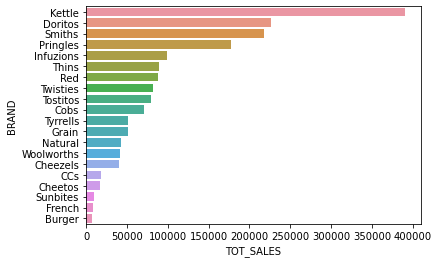

In [150]:
Grpx = pd.DataFrame(ChipPurchases.groupby(['BRAND']).sum()['TOT_SALES'])
Grpx = Grpx.sort_values(by = 'TOT_SALES', ascending = False)
sns.barplot(y = Grpx.index, x = Grpx.TOT_SALES)

### Total Sales by Premium Customer and Lifestage.
Here, I decide to filter the total sales by both Premium Customers and LifeStage to see which group of customers are actually the best to focus on.

In [102]:
Grp1 = pd.DataFrame(ChipPurchases.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).sum()['TOT_SALES']).unstack(1)
Grp1

TOT_SALES                      
PREMIUM_CUSTOMER           Budget Mainstream    Premium
LIFESTAGE                                              
MIDAGE SINGLES/COUPLES   33345.70   84734.25   54443.85
NEW FAMILIES             20607.45   15979.70   10760.80
OLDER FAMILIES          156863.75   96413.55   75242.60
OLDER SINGLES/COUPLES   127833.60  124648.50  123537.55
RETIREES                105916.30  145168.95   91296.65
YOUNG FAMILIES          129717.95   86338.25   78571.70
YOUNG SINGLES/COUPLES    57122.10  147582.20   39052.30

<AxesSubplot:ylabel='LIFESTAGE'>

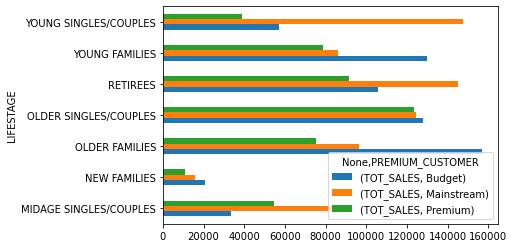

In [103]:
Grp1.plot(kind = 'barh',
          subplots = False, sharex=True,
          legend=True)
# L = plt.legend()
# L.get_texts()[0].set_text('Budget')
# L.get_texts()[1].set_text('Mainstream')
# L.get_texts()[2].set_text('Premium')

#### Discussion.
The plot above suggests that it's worth targetting the older singles/couples as they're the majority of our sales across multiple categories - Budget and Mainstream. It may also be worth targetting the young singles/couples as they're the top contributor for the mainstream group, and the older families for the budget group.

### Average Product Quantity by Premium Customer and Lifestage.
This is where I look at the average quantity bought by customers across both categories.

In [136]:
Grp2 = pd.DataFrame(ChipPurchases.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).mean()['PROD_QTY']).unstack(1)
Grp2

PROD_QTY                     
PREMIUM_CUSTOMER          Budget Mainstream   Premium
LIFESTAGE                                            
MIDAGE SINGLES/COUPLES  1.893626   1.911942  1.891750
NEW FAMILIES            1.855878   1.858124  1.860887
OLDER FAMILIES          1.945384   1.948795  1.945496
OLDER SINGLES/COUPLES   1.914920   1.911201  1.913949
RETIREES                1.893286   1.886680  1.901438
YOUNG FAMILIES          1.941226   1.941408  1.938149
YOUNG SINGLES/COUPLES   1.808002   1.853510  1.807075

(1.75, 1.975)

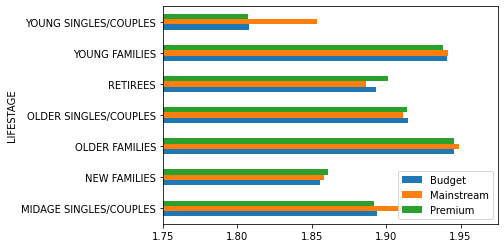

In [137]:
Grp2.plot(kind = 'barh',
          subplots = False, sharex=True,
          legend=True)
L = plt.legend()
L.get_texts()[0].set_text('Budget')
L.get_texts()[1].set_text('Mainstream')
L.get_texts()[2].set_text('Premium')
plt.xlim([1.75, 1.975])

#### Discussion.
The plot above shows that all of our customers purchase more than one packet at a time, with most of them purchase more than two. The common trend in the plot is that the customers that have families are most likely to purchase two packets on average across all three streams.

### Average Product Price by Premium Customer and Lifestage.

In [42]:
ChipPurchases['PRICE'] = ChipPurchases['TOT_SALES']/ChipPurchases['PROD_QTY']
Grp3 = pd.DataFrame(ChipPurchases.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).mean()['PRICE']).unstack()
Grp3

PRICE                     
PREMIUM_CUSTOMER          Budget Mainstream   Premium
LIFESTAGE                                            
MIDAGE SINGLES/COUPLES  3.743328   3.994241  3.770698
NEW FAMILIES            3.917688   3.916133  3.872110
OLDER FAMILIES          3.745340   3.737077  3.717000
OLDER SINGLES/COUPLES   3.882096   3.814665  3.893182
RETIREES                3.924404   3.844294  3.920942
YOUNG FAMILIES          3.760737   3.724533  3.762150
YOUNG SINGLES/COUPLES   3.657366   4.065642  3.665414

(3.6, 4.1)

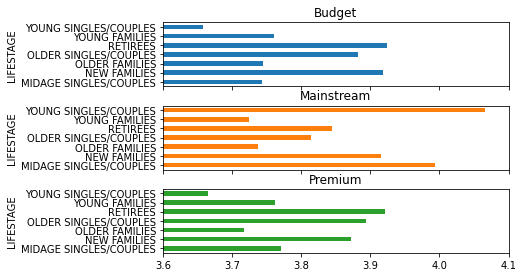

In [43]:
Grp3.plot(kind = 'barh',
          subplots = True, sharex=True,
          title=['Budget', 'Mainstream', 'Premium'],
          legend=None)
plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 1, 
                    hspace = 0.3);
plt.xlim([3.6, 4.1])

#### Discussion.
The plot above shows that the mainstream young singles/couples are more willing to spend more on chips than the others by a significant amount, followed by the midage singles/couples from the same category. The older customers are more frugal and tend to spend less than their younger counterparts.

In addition to that, our premium customers are a lot more frugal across the board and do not spend much money on chips. This could be because they'd prefer to eat more healthily and spend more money on that food group instead.

However, one thing to note is that the values are very similar to one another. Therefore, it may be worth performing a t-test to see if the difference in prices are statistically significant.

### Independent T-Test.
Here, I perform a t-test on the two groups. The first group will consist of mainstream young and midage singles/couples, and the second group will be the young and midage singles/couples from the other two categories, Budget and Premium.

In [44]:
Mainstream = ChipPurchases[(ChipPurchases['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']) & 
               (ChipPurchases['PREMIUM_CUSTOMER'] == 'Mainstream'))]

Others = ChipPurchases[(ChipPurchases['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']) & 
               (ChipPurchases['PREMIUM_CUSTOMER'] != 'Mainstream'))]

ttest_ind(Mainstream['PRICE'], Others['PRICE'])

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

#### Discussion.
Since the p-value is so close to 0 and the t-statistic being as high as it is, there is <font color = 'red'>**sufficient evidence to reject the null hypothesis**</font> that the unit price for mainstream, young and midage singles/couples is equal to the unit price for budget and premium young and midage singles/couples.

Now that we've affirmed this, it may be worth looking into which brands would be preferred by the mainstream young singles/couples based on what they've already purchased. This could be done via an **A-priori analysis**.
This will be done twice - once on the brands, and a second time on the size of the packets.

### A-Priori Analysis of Brands.

In [45]:
Young = Mainstream[Mainstream['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES']
Young = Young[['LYLTY_CARD_NBR', 'DATE', 'BRAND']].reset_index(drop = True)

Items = [x[1]['BRAND'].tolist() for x in list(Young.groupby(['LYLTY_CARD_NBR', 'DATE']))]
Items

[['Red'],
 ['Doritos'],
 ['Kettle'],
 ['Red'],
 ['Infuzions'],
 ['Smiths'],
 ['Smiths'],
 ['Grain'],
 ['Tyrrells'],
 ['Twisties'],
 ['Doritos'],
 ['Doritos'],
 ['Doritos'],
 ['Cobs'],
 ['Infuzions'],
 ['Pringles'],
 ['Smiths'],
 ['Doritos'],
 ['Grain'],
 ['Pringles'],
 ['Kettle'],
 ['Natural'],
 ['Infuzions'],
 ['Red'],
 ['Pringles'],
 ['Kettle'],
 ['Smiths'],
 ['Doritos'],
 ['Cheezels'],
 ['Twisties'],
 ['Red'],
 ['Infuzions'],
 ['Pringles'],
 ['Pringles'],
 ['Smiths'],
 ['Burger'],
 ['Red'],
 ['Smiths'],
 ['Sunbites'],
 ['Woolworths'],
 ['Woolworths'],
 ['Doritos'],
 ['Thins'],
 ['Kettle'],
 ['Red'],
 ['Doritos'],
 ['Natural'],
 ['Kettle'],
 ['Kettle'],
 ['Infuzions'],
 ['Red'],
 ['Smiths'],
 ['Infuzions'],
 ['Kettle'],
 ['Kettle'],
 ['Pringles'],
 ['Tostitos'],
 ['Sunbites'],
 ['Doritos'],
 ['Red'],
 ['Kettle'],
 ['Twisties'],
 ['Grain'],
 ['Thins'],
 ['Red'],
 ['Tyrrells'],
 ['Cobs'],
 ['Red'],
 ['Kettle'],
 ['Kettle'],
 ['Woolworths'],
 ['Doritos'],
 ['Smiths'],
 ['Smiths'],
 ['Wo

In [46]:
te = TransactionEncoder()
te_ary = te.fit(Items).transform(Items)

Brand_Trans = pd.DataFrame(te_ary, columns=te.columns_)
Brand_Trans

,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain,Infuzions,Kettle,Natural,Pringles,Red,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19477,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
19478,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
19479,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
19480,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [47]:
Brand_Freq = apriori(Brand_Trans, min_support = 1e-5, use_colnames = True)

# Collecting the inferred rules in a dataframe.
Brand_Rules = association_rules(Brand_Freq, metric = "lift", min_threshold = 0.05)
Brand_Rules = Brand_Rules.sort_values(['confidence', 'lift'], ascending =[False, False])
Brand_Rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,"(Pringles, Twisties)",(Doritos),0.000051,0.122061,0.000051,1.000000,8.192599,0.000045,inf
16,"(Twisties, Doritos)",(Pringles),0.000154,0.118828,0.000051,0.333333,2.805184,0.000033,1.321759
15,"(Pringles, Doritos)",(Twisties),0.000205,0.046196,0.000051,0.250000,5.411667,0.000042,1.271738
1,(Burger),(Pringles),0.003182,0.118828,0.000051,0.016129,0.135735,-0.000327,0.895618
9,(French),(Natural),0.004004,0.020224,0.000051,0.012821,0.633932,-0.000030,0.992501
6,(French),(Cobs),0.004004,0.044349,0.000051,0.012821,0.289085,-0.000126,0.968062
3,(Sunbites),(CCs),0.006570,0.011395,0.000051,0.007812,0.685600,-0.000024,0.996389
4,(Cheetos),(Woolworths),0.008521,0.024587,0.000051,0.006024,0.245013,-0.000158,0.981325
2,(CCs),(Sunbites),0.011395,0.006570,0.000051,0.004505,0.685600,-0.000024,0.997925
10,(Grain),(Thins),0.033159,0.059850,0.000103,0.003096,0.051729,-0.001882,0.943070


#### Discussion.
The analysis suggests customers who bought: 
* **Woolworths** are more likely to buy **Cheetos** and **Grai**n as well.
* **French** are more likely to buy **Natural** and **Cobs** as well.
* **Pringles** are more likely to buy **Twisties**, **Doritos** and **Burger** as well.

### A-Priori Analysis of Pack Sizes.

In [48]:
Young2 = Mainstream[Mainstream['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES']
Size = Young2['PROD_NAME'].apply(lambda x: re.findall('\d+', x))

Young2['PACKET_SIZE'] = list(chain.from_iterable(Size))
Young2 = Young2[['LYLTY_CARD_NBR', 'DATE', 'PACKET_SIZE']].reset_index(drop = True).set_index('LYLTY_CARD_NBR')

Size = [x[1]['PACKET_SIZE'].tolist() for x in list(Young2.groupby(['LYLTY_CARD_NBR', 'DATE']))]
Size

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\HP-user\AppData\Local\Temp\ipykernel_9056\1694946960.py:2: DeprecationWarning: invalid escape sequence \d
  Size = Young2['PROD_NAME'].apply(lambda x: re.findall('\d+', x))
C:\Users\HP-user\AppData\Local\Temp\ipykernel_9056\1694946960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Young2['PACKET_SIZE'] = list(chain.from_iterable(Size))


[['150'],
 ['170'],
 ['150'],
 ['165'],
 ['70'],
 ['150'],
 ['330'],
 ['180'],
 ['165'],
 ['270'],
 ['170'],
 ['170'],
 ['170'],
 ['110'],
 ['110'],
 ['134'],
 ['380'],
 ['330'],
 ['210'],
 ['134'],
 ['175'],
 ['175'],
 ['110'],
 ['150'],
 ['134'],
 ['175'],
 ['170'],
 ['170'],
 ['330'],
 ['250'],
 ['150'],
 ['110'],
 ['134'],
 ['134'],
 ['380'],
 ['220'],
 ['165'],
 ['175'],
 ['90'],
 ['200'],
 ['160'],
 ['150'],
 ['175'],
 ['175'],
 ['150'],
 ['170'],
 ['175'],
 ['150'],
 ['175'],
 ['110'],
 ['165'],
 ['330'],
 ['110'],
 ['150'],
 ['175'],
 ['134'],
 ['175'],
 ['90'],
 ['170'],
 ['150'],
 ['150'],
 ['250'],
 ['180'],
 ['175'],
 ['150'],
 ['165'],
 ['110'],
 ['150'],
 ['150'],
 ['150'],
 ['160'],
 ['170'],
 ['175'],
 ['150'],
 ['175'],
 ['134'],
 ['165'],
 ['175'],
 ['134'],
 ['165'],
 ['170'],
 ['110'],
 ['150'],
 ['380'],
 ['134'],
 ['175'],
 ['134'],
 ['380'],
 ['150'],
 ['330'],
 ['330'],
 ['380'],
 ['160'],
 ['150'],
 ['210'],
 ['150'],
 ['160'],
 ['150'],
 ['170'],
 ['110'],
 ['

In [49]:
te_ary2 = te.fit(Size).transform(Size)

Size_Trans = pd.DataFrame(te_ary2, columns=te.columns_)
Size_Trans

,110,125,134,135,150,160,165,170,175,180,190,200,210,220,250,270,330,380,70,90
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19477,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
19478,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
19479,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
19480,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [50]:
Size_Freq = apriori(Size_Trans, min_support = 1e-5, use_colnames = True)

# Collecting the inferred rules in a dataframe.
Size_Rules = association_rules(Size_Freq, metric = "lift", min_threshold = 0.05)
Size_Rules = Size_Rules.sort_values(['confidence', 'lift'], ascending =[False, False])
Size_Rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,"(380, 134)",(270),0.000051,0.031824,0.000051,1.000000,31.422581,0.000050,inf
14,"(270, 134)",(380),0.000051,0.032132,0.000051,1.000000,31.121406,0.000050,inf
12,"(380, 270)",(134),0.000051,0.118828,0.000051,1.000000,8.415551,0.000045,inf
2,(220),(134),0.003182,0.118828,0.000051,0.016129,0.135735,-0.000327,0.895618
0,(70),(110),0.003234,0.105225,0.000051,0.015873,0.150848,-0.000289,0.909207
4,(70),(150),0.003234,0.157992,0.000051,0.015873,0.100467,-0.000460,0.855589
7,(180),(175),0.003593,0.256288,0.000051,0.014286,0.055741,-0.000870,0.754491
9,(190),(200),0.007597,0.009188,0.000051,0.006757,0.735392,-0.000018,0.997552
8,(200),(190),0.009188,0.007597,0.000051,0.005587,0.735392,-0.000018,0.997979
16,(270),"(380, 134)",0.031824,0.000051,0.000051,0.001613,31.422581,0.000050,1.001564


#### Discussion.
The analysis suggests customers who bought:
* **70g** packets are more likely to buy the **110g** and **150g** packets.
* **270g** packets are more likely to buy the **134g** and the **380g** packets.
* **134g** packets are more likely to buy the **220g**, **270g** and **380g** packets.